In [1]:
# describe things you have done: 
#e.g. load all data by pandas - Zhennong 

In [ ]:
# --- Dec.7 updata ---
# --- Zhennong ---
# Env: python 3.7

# Done:
# clean the data

# TODO:
# Plot the distribution of overall score, fit a Gaussian onto that
# plot the correlation between overall score and each attribute


In [4]:
# --- Dec.7 updata ---
# --- yifan ---
# Env: python 3.7

# Done:
# extract features that we need from raw dataset
# transform 'Value' into real number
# transform 'Preferred positions' into single one target position
# predict overall score using linear regression
# classify position using logistic regression

# TODO:
# result of linear coefficient looks weird, e.g. 'Positioning' has negative effect ?
# we should rule out data points of GK

In [216]:
#import all the necessary packages:
import pandas as pd
import statistics
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Clean the data

In [1]:
#load the data, use first column as the index of the dataframe
df=pd.read_csv("data/CompleteDataset.csv",index_col=0)

NameError: name 'pd' is not defined

In [8]:
#clean data: data including calculations should be cleaned to be just one number.
print("unique values, column 66\n\n", df.iloc[:,66].unique())

#function for cleaning:
def clean(x):
    # evaluate sum
    if('+' in str(x).strip()):
        cal = x.split('+')
        return int(cal[0]) + int(cal[1])
    # evaluate subtraction
    elif('-' in str(x).strip()):
        cal = x.split('-')
        return int(cal[0]) + int(cal[1])
    # convert to all float points to integer 
    elif str(x).strip().isdigit():
        return int(x)
    # return as 0 if null values or NaN values
    elif pd.isnull(x):
         return 0
    # return other type (e.g. object) as the way it is.
    else: 
        return x
for column in df.iloc[:,11:74]:
    df[column] = df[column].apply(clean)
for column in df.iloc[:,5:7]:
    df[column] = df[column].apply(clean)
# save the modfied dataframe
df.to_csv("data/CompleteDataset_clean.csv")

unique values, column 66

 [82. 84. 79. 80. nan 78. 81. 87. 71. 74. 86. 75. 60. 76. 85. 73. 69. 77.
 83. 72. 63. 67. 55. 65. 70. 56. 68. 62. 57. 66. 64. 61. 58. 54. 59. 53.
 50. 46. 51. 49. 47. 45. 52. 43. 48. 42. 44. 40. 41. 39. 38. 37. 35. 36.
 34. 32. 33. 31. 30.]


## Data Preprocessing - convert values and register targeted position

In [195]:
# FIFA18 dataset
# https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset
# yfzhou
# Nov, 2018


In [196]:
# read data and show some examples

filename = "data/CompleteDataset_clean.csv"

df = pd.read_csv(filename)
print(df.columns)
# df.head(5)

Index(['Unnamed: 0', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')


In [197]:
# choose some of features we need

columns_needed = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'Overall', 'Value', 'Preferred Positions']

df = df[columns_needed]
print(df.columns)

Index(['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys', 'Overall', 'Value', 'Preferred Positions'],
      dtype='object')


In [198]:
# the data under 'Value' need to be converted into int/float

# convert K to M
df['Unit'] = df['Value'].str[-1]
df['Value (M)'] = np.where(df['Unit'] == '0', 0, df['Value'].str[1:-1].replace(r'[a-zA-Z]',''))
df['Value (M)'] = df['Value (M)'].astype(float)
df['Value (M)'] = np.where(df['Unit'] == 'M', df['Value (M)'], df['Value (M)']/1000)
df = df.drop('Unit', 1)
df = df.drop('Value', 1)

In [199]:
# data under 'Preferred Positions' has multiple positions, the first one is selected as target

df['Target Position'] = df['Preferred Positions'].str.split().str[0]
df = df.drop('Preferred Positions', 1)
print(df.columns)

Index(['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys', 'Overall', 'Value (M)', 'Target Position'],
      dtype='object')


In [200]:
# transform target position into number representation
# e.g. there are four categories: GK, Forward, Midfield, Backfield
# feel free to play with the mapping relation

mapping = {'CF': 0,'ST': 0, 'RW': 0, 'LW': 0, 'RM': 1, 'CM': 1, 'LM': 1, 'CAM': 1, 'CDM': 1, 'CB': 2, 'LB': 2, 'RB': 2, 'RWB': 2, 'LWB': 2, 'GK': 3}
df = df.replace({'Target Position': mapping})


In [201]:
df.isnull().values.any()

False

## Plot the distribution of Overall scores

In [202]:
#simple statistics for overall scores
overall=df.iloc[:,29]
print(overall.describe())

count    17981.000000
mean        66.247984
std          6.987965
min         46.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64


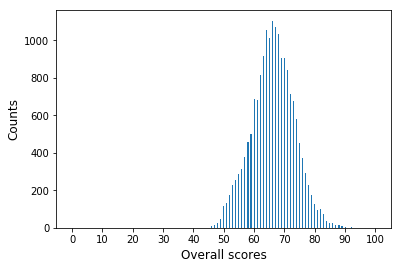

In [235]:
x=np.linspace(0,100,101)
y=np.array([0]*101)
for i in range(0,len(overall)):
      y[overall[i]]+=1

plt.bar(x,y,width=0.35,label='overall scores')
plt.ylabel('Counts',fontsize=12)
plt.xlabel('Overall scores',fontsize=12);
plt.xticks(np.arange(0,101,10))
plt.savefig('overall score distribution.pdf',bbox_inches = 'tight')

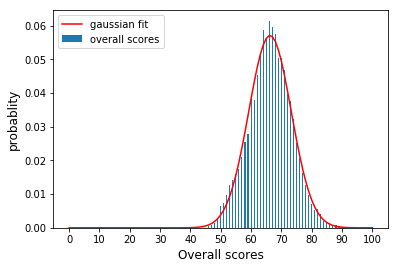

In [233]:
#turn the counts to probability
#fit a Gaussian function onto the plot to show the distribution can be approximated as a normal distribution.
summation=overall.value_counts().sum()
y_prob=np.zeros(101)
for i in range(0,len(y)):
    y_prob[i] =y[i]*1.0/summation
mean=66.247984
variance=6.987965**2
x=np.linspace(0.0,100.0,101)
y_gaus=np.zeros(101)
for i in range(0,len(y)):
    y_gaus[i]=1/(math.sqrt(2*math.pi*variance))*np.exp(-((i-mean)**2)/(2*variance))


plt.bar(x,y_prob,width=0.35,label='overall scores')
plt.plot(x,y_gaus,'r',label='gaussian fit')
plt.legend()
plt.ylabel('probablity',fontsize=12)
plt.xlabel('Overall scores',fontsize=12);
plt.xticks(np.arange(0,101,10))
plt.savefig('overall score distribution gaussian fitted.pdf',bbox_inches = 'tight')

## Correlation between attributes and overall scores

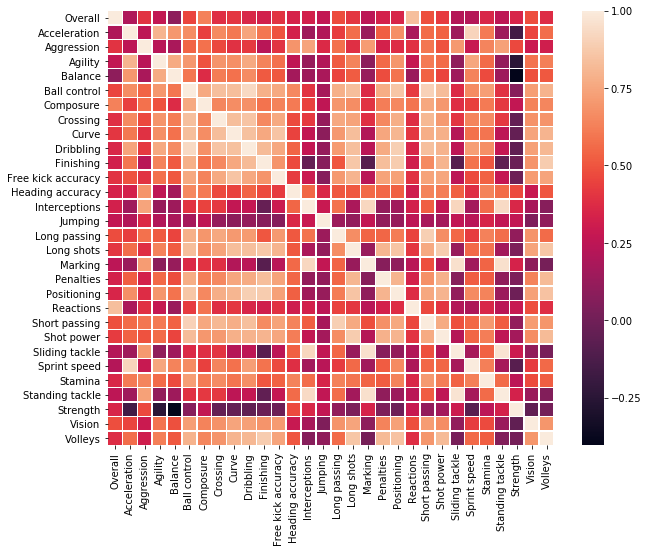

In [232]:
attributes=np.concatenate([np.array([29]),np.arange(0,29)])
df_performance=df.iloc[:,attributes]
corr=df_performance.corr()
fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(corr,linewidths=.5,ax=ax)
plt.savefig('correlation of attributes.pdf',bbox_inches = 'tight')

## Predict Overall -- linear regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-3], df.iloc[:,-3], test_size=0.1, random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

X train shape: (16182, 29)
X test shape: (1799, 29)
y train shape: (16182,)
y test shape: (1799,)


In [17]:
clf = LinearRegression().fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Linear Regression R^2 coef: {}'.format(acc))

Linear Regression R^2 coef: 0.7700273879214501


In [18]:
feature_result = [(X_train.columns[i], clf.coef_[i]) for i in range(len(clf.coef_))]
feature_result_sort = sorted(feature_result, key = lambda x : x[1])
feature_result_sort

# it looks weird, for example, positioning have negative effect on overall
# maybe reason is that position for GK is pretty low

[('Positioning', -0.08729696809215812),
 ('Balance', -0.051142527638434944),
 ('Dribbling', -0.033535661161879615),
 ('Sliding tackle', -0.02543833812905039),
 ('Heading accuracy', -0.022801064786869912),
 ('Stamina', -0.018578880002225226),
 ('Penalties', -0.016703326515214913),
 ('Aggression', -0.01134510083193199),
 ('Agility', -0.002246995612553776),
 ('Standing tackle', -0.0019288500669527892),
 ('Free kick accuracy', -0.0017008719598030993),
 ('Volleys', -0.0016078850046753201),
 ('Long shots', -0.0006441727819336877),
 ('Marking', -0.0003143225995172301),
 ('Interceptions', 0.0026801620035121375),
 ('Long passing', 0.008573303435955264),
 ('Curve', 0.009068322711823675),
 ('Shot power', 0.009810992600231685),
 ('Finishing', 0.010752007407930466),
 ('Acceleration', 0.017230757274359555),
 ('Sprint speed', 0.03005699867511938),
 ('Crossing', 0.031012417321654773),
 ('Jumping', 0.03725527572093278),
 ('Vision', 0.03829656644653301),
 ('Short passing', 0.04159958257420677),
 ('Stren

## Classify position -- logistic regression

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-3], df.iloc[:,-1], test_size=0.1, random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

X train shape: (16182, 29)
X test shape: (1799, 29)
y train shape: (16182,)
y test shape: (1799,)


In [20]:
clf = LogisticRegression().fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Logistic Regression accuracy: {}'.format(acc))

Logistic Regression accuracy: 0.8160088938299055
